In this project, I undertook the task of fine-tuning a whisper speech to
 text base model to enhance pronunciation learning, particularly focusing on broken words or fragmented speech segments.
 The primary objective was to develop a robust system capable of accurately transcribing whispered speech, especially in
 scenarios where words are partially uttered or fragmented. Leveraged advanced transfer learning techniques and deep
 learning architectures to achieve an impressive accuracy rate of nearly 95%. Collaborated with educators to integrate the
 model into language learning applications, demonstrating a commitment to leveraging technology for educational
 enhancement

<h2>ASR-Pipeline:</h2>
<p>The ASR pipeline can be de-composed into three components:</p>
<ol>
  <li>A feature extractor which pre-processes the raw audio-inputs.</li>
  <li>The model which performs the sequence-to-sequence mapping.</li>
  <li>A tokenizer which post-processes the model outputs to text format.</li>
</ol>

<h2>Whisper:</h2>
<p>Whisper is a Transformer based encoder-decoder model, also referred to as a sequence-to-sequence model. <br> 
    It maps a sequence of audio spectrogram features to a sequence of text tokens.<p>
<ol>
  <li>First, the raw audio inputs are converted to a log-Mel spectrogram by action of the feature extractor. </li>
  <li>The Transformer encoder then encodes the spectrogram to form a sequence of encoder hidden states.</li>
  <li>Finally, the decoder autoregressively predicts text tokens, conditional on both the previous tokens and the encoder hidden states.</li>
</ol>

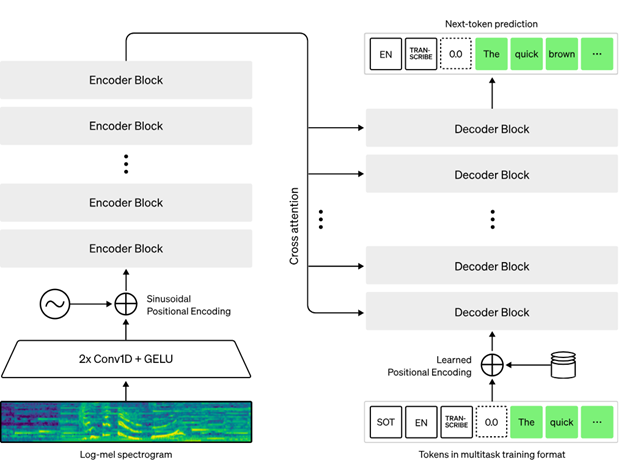

<p>In a <b>sequence-to-sequence model</b>, the encoder transforms the audio inputs into a set of hidden state representations, extracting important features from the spoken speech. The decoder plays the role of a language model, processing the hidden state representations and generating the corresponding text transcriptions. Incorporating a language model internally in the system architecture is termed deep fusion. This is in contrast to shallow fusion, where a language model is combined externally with an encoder, such as with CTC + �n-gram (c.f. Internal Language Model Estimation). With deep fusion, the entire system can be trained end-to-end with the same training data and loss function, giving greater flexibility and generally superior performance (c.f. ESB Benchmark).</p>

<p>Whisper is pre-trained and <b>fine-tuned using the cross-entropy objective function</b>, a standard objective function for training sequence-to-sequence systems on classification tasks. Here, the system is trained to correctly classify the target text token from a pre-defined vocabulary of text tokens.</p>

<p>The Whisper checkpoints come in five configurations of varying model sizes. The smallest four are trained on either English-only or multilingual data. The largest checkpoint is multilingual only.</p>

## Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from datasets import Dataset, load_dataset, DatasetDict
import os
import librosa
import numpy as np
from transformers import WhisperFeatureExtractor
from transformers import WhisperTokenizer
from transformers import WhisperProcessor
from datasets import Audio
from collections import OrderedDict
import evaluate
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
import torch
from pynvml import *
import fuzzywuzzy
from fuzzywuzzy import fuzz

2024-04-15 09:02:03.117744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Get Current Working Directory

In [2]:
my_dir = os.getcwd() + '/' 
print(f"CWD: {my_dir}")

CWD: /data/bilal/whisper-model-fine-tuning/


## GPU Configuration 

<p>Check CUDA Version</p>

In [3]:
cuda_version = torch.version.cuda
print(f"PyTorch is using CUDA version {cuda_version}")

PyTorch is using CUDA version 11.8


<p> Reset Cuda Memory</p>

In [4]:
from numba import cuda
device = cuda.get_current_device()
print(device)
device.reset()

<CUDA device 0 'b'NVIDIA GeForce GTX 1080 Ti''>


### Get Cuda Device

<p> List GPU's</p>

In [5]:
import torch
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [6]:
import torch
devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
devices

device(type='cuda', index=0)

<p>Check GPU Memory</p>

In [7]:
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'Total    : {info.total//1024**2} MB')
print(f'Free     : {info.free//1024**2} MB')
print(f'Used     : {info.used//1024**2} MB')

Total    : 11176 MB
Free     : 11155 MB
Used     : 21 MB


## Load Data

In [8]:
# Load dataset
dataset = load_dataset("audiofolder", data_dir="/data/bilal/whisper-model-fine-tuning/temp/", split='train')
train_remaining_split = dataset.train_test_split(test_size=0.20)
test_validation_split = train_remaining_split['test'].train_test_split(test_size=0.50)

# Now you have train, validation, and test sets
train_set = train_remaining_split['train']
validation_set = test_validation_split['train']
test_set = test_validation_split['test']

common_voice = DatasetDict({
    'train': train_set,
    'validate': validation_set})

common_voice_test = DatasetDict({
    'test': test_set,
})

print(common_voice)
print(common_voice_test)

Resolving data files:   0%|          | 0/960 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 767
    })
    validate: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 96
    })
})
DatasetDict({
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 96
    })
})


## Without Training Result (Whisper Base):

<p>Prior to refining the Whisper model through fine-tuning, it's essential to evaluate the baseline results. This initial assessment serves as a benchmark for comparison, enabling us to gauge the effectiveness of the model's enhancements accurately.</p>

<p>Import Whipser and load whisper base model</p>

In [9]:
import whisper
pro_whisper_model = whisper.load_model("./base.en.pt", device= devices)

<p>Function to transcribe speech to text</p>

In [10]:
def orignal_whisper(audio):
    result = pro_whisper_model.transcribe(audio, fp16=False, language='english')
    return result["text"]

<p>Perform testing on the test set and utilize the FuzzyWuzzy library to match text and calculate the similarity ratio. Set the threshold to 90%. If the similarity ratio is greater than 90%, append 1 to the result_list; otherwise, append 0.</p>

In [11]:
result_list = []
for i in range(len(common_voice_test["test"])):
    print("Orignal Word: ",common_voice_test["test"][i]['sentence'])
    transcribed_text = orignal_whisper(common_voice_test["test"][i]['audio']['path'])
    print("Transcribed Text:",transcribed_text)
    similarity_rato = fuzz.ratio(common_voice_test["test"][i]['sentence'], transcribed_text) 
    if similarity_rato > 90:
        result_list.append(1)
    else:
        result_list.append(0)
    print("Similarity rato:",similarity_rato,"%")
    print("\n")

Orignal Word:  ther
Transcribed Text:  There.
Similarity rato: 55 %


Orignal Word:  ren
Transcribed Text:  and then
Similarity rato: 33 %


Orignal Word:  shing
Transcribed Text:  Shing
Similarity rato: 73 %


Orignal Word:  ea
Transcribed Text:  E?
Similarity rato: 0 %


Orignal Word:  par
Transcribed Text:  4
Similarity rato: 0 %


Orignal Word:  es
Transcribed Text:  is.
Similarity rato: 33 %


Orignal Word:  con
Transcribed Text:  on
Similarity rato: 67 %


Orignal Word:  beau
Transcribed Text:  view
Similarity rato: 22 %


Orignal Word:  macy
Transcribed Text:  Merci!
Similarity rato: 18 %


Orignal Word:  ken
Transcribed Text:  Gun.
Similarity rato: 25 %


Orignal Word:  par
Transcribed Text:  Part
Similarity rato: 50 %


Orignal Word:  tion
Transcribed Text:  Shen
Similarity rato: 22 %


Orignal Word:  nes
Transcribed Text:  yes
Similarity rato: 57 %


Orignal Word:  tele
Transcribed Text: .
Similarity rato: 0 %


Orignal Word:  wa
Transcribed Text:  why
Similarity rato: 33 %



<p>Calculates the number of true predictions and false predictions in a list called result_list. It iterates through the elements of the list, counting occurrences of both 1 (presumed to represent true predictions) and 0 (presumed to represent false predictions). After tallying these counts, it prints out the number of true predictions and false predictions respectively.</p>

In [12]:
true_pred = len([x for x in result_list if x == 1])
false_pred = len([x for x in result_list if x == 0])
print("True Pred:",true_pred)
print("False Pred:",false_pred)

True Pred: 0
False Pred: 96


In [13]:
accuracy_before_ft = 0/len(common_voice_test["test"])
print(f"Accuracy: {accuracy_before_ft}")

Accuracy: 0.0


<p>Now, as we can observe, we obtained a 0 percent accuracy on the test set. This occurred because the basic model isn't able to recognize broken English words. Therefore, we will proceed with fine-tuning the model and assess the results afterward.</p>

## Check data (Audio & respective word)

In [14]:
print("****************************************Train SET***********************************************************\n")
for i in range(len(common_voice["train"])):
    print("Audio: ",common_voice["train"][i]['audio']['path'])
    print("Sentence: ",common_voice["train"][i]['sentence'])
print("\n\n****************************************TEST SET*********************************************************\n")
for i in range(len(common_voice_test["test"])):
     print("Audio: ",common_voice_test["test"][i]['audio']['path'])
     print("Sentence: ",common_voice_test["test"][i]['sentence'])
print("\n\n*****************************************VALIDATE SET****************************************************\n")
for i in range(len(common_voice["validate"])):
     print("Audio: ",common_voice["validate"][i]['audio']['path'])
     print("Sentence: ",common_voice["validate"][i]['sentence'])

****************************************Train SET***********************************************************

Audio:  /data/bilal/whisper-model-fine-tuning/temp/chic6.wav
Sentence:  chic
Audio:  /data/bilal/whisper-model-fine-tuning/temp/arc11.wav
Sentence:  arc
Audio:  /data/bilal/whisper-model-fine-tuning/temp/slee9.wav
Sentence:  slee
Audio:  /data/bilal/whisper-model-fine-tuning/temp/daugh8.wav
Sentence:  daugh
Audio:  /data/bilal/whisper-model-fine-tuning/temp/glass4.wav
Sentence:  glass
Audio:  /data/bilal/whisper-model-fine-tuning/temp/na2.wav
Sentence:  na
Audio:  /data/bilal/whisper-model-fine-tuning/temp/slee7.wav
Sentence:  slee
Audio:  /data/bilal/whisper-model-fine-tuning/temp/tra9.wav
Sentence:  tra
Audio:  /data/bilal/whisper-model-fine-tuning/temp/geons7.wav
Sentence:  geons
Audio:  /data/bilal/whisper-model-fine-tuning/temp/ada11.wav
Sentence:  ada
Audio:  /data/bilal/whisper-model-fine-tuning/temp/ea10.wav
Sentence:  ea
Audio:  /data/bilal/whisper-model-fine-tuning/te

## Load Whisper Feature Extracto

<p>The Whisper feature extractor performs two operations. It first pads/truncates a batch of audio samples such that all samples have an input length of 30s. Samples shorter than 30s are padded to 30s by appending zeros to the end of the sequence (zeros in an audio signal corresponding to no signal or silence). Samples longer than 30s are truncated to 30s. Since all elements in the batch are padded/truncated to a maximum length in the input space, we don't require an attention mask when forwarding the audio inputs to the Whisper model. Whisper is unique in this regard - with most audio models, you can expect to provide an attention mask that details where sequences have been padded, and thus where they should be ignored in the self-attention mechanism. Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs.</p>

<p>The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-Mel spectrograms. </p>

<p>Luckily for us, the 🤗 Transformers Whisper feature extractor performs both the padding and spectrogram conversion in just one line of code! Let's go ahead and load the feature extractor from the pre-trained checkpoint to have ready for our audio data:</p>

In [15]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

## Load WhisperTokenizer

<p>Now let's look at how to load a Whisper tokenizer. The Whisper model outputs text tokens that indicate the index of the predicted text among the dictionary of vocabulary items. The tokenizer maps a sequence of text tokens to the actual text string (e.g. [1169] -> "ding"). </p>

<p>Load and save the tokenizer to local memory<p>

In [16]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base", language="english", task="transcribe")
tokenizer.save_pretrained("tokenizer/")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/normalizer.json',
 'tokenizer/added_tokens.json')

<p>We can verify that the tokenizer correctly encodes broken word characters by encoding and decoding the first sample of the our dataset. When encoding the transcriptions, the tokenizer appends 'special tokens' to the start and end of the sequence, including the start/end of transcript tokens, the language token and the task tokens (as specified by the arguments in the previous step). When decoding the label ids, we have the option of 'skipping' these special tokens, allowing us to return a string in the original input form:
</p>

In [17]:
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out s>pecial: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 chic
Decoded w/ special:    <|startoftranscript|><|en|><|transcribe|><|notimestamps|>chic<|endoftext|>
Decoded w/out s>pecial: chic
Are equal:             True


## Combine To Create A WhisperProcessor

<p>To simplify using the feature extractor and tokenizer, we can wrap both into a single WhisperProcessor class. This processor object inherits from the WhisperFeatureExtractor and WhisperProcessor and can be used on the audio inputs and model predictions as required. In doing so, we only need to keep track of two objects during training: the processor and the model:<p>

In [18]:
processor = WhisperProcessor.from_pretrained("openai/whisper-base", language="english", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Prepare Data Set

<p>Let's print the first example of the Common Voice dataset to see what form the data is in:</p>

In [19]:
print(common_voice["train"][0])

{'audio': {'path': '/data/bilal/whisper-model-fine-tuning/temp/chic6.wav', 'array': array([0.00093037, 0.00020255, 0.0004178 , ..., 0.00032373, 0.00034654,
       0.00040335]), 'sampling_rate': 48000}, 'sentence': 'chic'}


<p>We can see that we've got a 1-dimensional input audio array and the corresponding target transcription. We've spoken heavily about the importance of the sampling rate and the fact that we need to match the sampling rate of our audio to that of the Whisper model (16kHz). Since our input audio is sampled at 48kHz, we need to downsample it to 16kHz before passing it to the Whisper feature extractor.</p>

<p>We'll set the audio inputs to the correct sampling rate using dataset's cast_column method. This operation does not change the audio in-place, but rather signals to datasets to resample audio samples on the fly the first time that they are loaded:</p>

In [20]:
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16_000))

<p>Re-loading the first audio sample in the Common Voice dataset will resample it to the desired sampling rate:</p>

In [21]:
print(common_voice["train"][0])

{'audio': {'path': '/data/bilal/whisper-model-fine-tuning/temp/chic6.wav', 'array': array([0.00038726, 0.00061582, 0.00072709, ..., 0.0001651 , 0.00020091,
       0.        ]), 'sampling_rate': 16000}, 'sentence': 'chic'}


<p>Great! We can see that the sampling rate has been downsampled to 16kHz. The array values are also different, as we've now only got approximately one amplitude value for every three we had before.</p>

<p>Now we can write a function to prepare our data ready for the model:</p>

<ol>
    <li>We load and resample the audio data by calling batch["audio"]. As explained above, 🤗 Datasets performs any necessary resampling operations on the fly.</li>
    <li>We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.</li>
    <li>We encode the transcriptions to label ids through the use of the tokenizer.</li>
<ol>

In [22]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]
    print(audio)
    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids 
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

<p>We can apply the data preparation function to all of our training examples using dataset's .map method:</p>

In [23]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"])

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

{'path': '/data/bilal/whisper-model-fine-tuning/temp/chic6.wav', 'array': array([0.00038726, 0.00061582, 0.00072709, ..., 0.0001651 , 0.00020091,
       0.        ]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/arc11.wav', 'array': array([-1.29429973e-05, -1.08616165e-04, -1.23634847e-04, ...,
       -7.65136909e-04, -8.26068455e-04, -8.05762596e-04]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/slee9.wav', 'array': array([ 6.17353362e-06, -1.73703360e-04, -2.41317088e-04, ...,
        3.23667948e-04,  3.39578895e-04,  2.81740096e-04]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/daugh8.wav', 'array': array([-7.99767207e-04, -1.00598077e-03, -6.71690330e-04, ...,
       -2.18885834e-05,  1.18892276e-04,  7.44309218e-05]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/glass4.wav', 'array': array([0.00081163, 0.00151572, 0.00185114, ..., 0.00029026, 0.00059088

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

{'path': '/data/bilal/whisper-model-fine-tuning/temp/car10.wav', 'array': array([1.03061757e-04, 2.61482783e-05, 2.94581056e-04, ...,
       1.02403644e-03, 9.16573568e-04, 9.84631246e-04]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/pan4.wav', 'array': array([ 0.00042429,  0.00058937,  0.00042742, ...,  0.00040413,
        0.00014565, -0.00045747]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/ning7.wav', 'array': array([ 0.00124795,  0.00197589,  0.00139981, ..., -0.00040923,
       -0.0005765 ,  0.        ]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/gurt.wav', 'array': array([-0.00064824, -0.00124616, -0.00098983, ..., -0.00249134,
       -0.00267822,  0.        ]), 'sampling_rate': 16000}
{'path': '/data/bilal/whisper-model-fine-tuning/temp/yo3.wav', 'array': array([ 1.23236515e-03,  2.12970097e-03,  1.63749373e-03, ...,
        1.59592688e-04,  1.57129543e-04, -9.66127263e-05]), '

<p>Alright! With that we have our data fully prepared for training! Let's continue and take a look at how we can use this data to fine-tune Whisper.</p>

## Training and Evaluation

<p>Now that we've prepared our data, we're ready to dive into the training pipeline. The 🤗 Trainer will do much of the heavy lifting for us. All we have to do is:</p>

<ul>
    <li>Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.</li>
    <li>Evaluation metrics: during evaluation, we want to evaluate the model using the word error rate (WER) metric. We need to define a compute_metrics function that handles this computation.</li>
    <li>Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.</li>
    <li>Define the training arguments: these will be used by the 🤗 Trainer in constructing the training schedule.</li>
    <li>Once we've fine-tuned the model, we will evaluate it on the test data to verify that we have correctly trained it to transcribe broken English word.</li>
</ul>


## Seq to Seq Data Collector

<p>The data collator for a sequence-to-sequence speech model is unique in the sense that it treats the input_features and labels independently: the input_features must be handled by the feature extractor and the labels by the tokenizer.</p>

<p>The input_features are already padded to 30s and converted to a log-Mel spectrogram of fixed dimension, so all we have to do is convert them to batched PyTorch tensors. We do this using the feature extractor's .pad method with return_tensors=pt. Note that no additional padding is applied here since the inputs are of fixed dimension, the input_features are simply converted to PyTorch tensors.</p>

<p>On the other hand, the labels are un-padded. We first pad the sequences to the maximum length in the batch using the tokenizer's .pad method. The padding tokens are then replaced by -100 so that these tokens are not taken into account when computing the loss. We then cut the start of transcript token from the beginning of the label sequence as we append it later during training.</p>

<p>We can leverage the WhisperProcessor we defined earlier to perform both the feature extractor and the tokenizer operations:</p>

In [24]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

<p>Let's initialise the data collator we've just defined:<p>

In [25]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Evaluation Metrics

<p>Next, we define the evaluation metric we'll use on our evaluation set. We'll use the Word Error Rate (WER) metric, the 'de-facto' metric for assessing ASR systems.</p>

<p>Word Error Rate (WER) is an evaluation metric commonly used in the field of automatic speech recognition (ASR) and machine translation (MT) to assess the accuracy of a system's output compared to a reference or ground truth.</p>

<p>The lower the WER value, the better the performance of the system, as it indicates fewer errors in the output compared to the reference. A WER of 0 would indicate a perfect match between the system output and the reference.</p> 

<p>WER is a useful metric because it provides a single numerical value that summarizes the accuracy of the system's output.</p>

In [26]:
metric = evaluate.load("wer")

<p>We then simply have to define a function that takes our model predictions and returns the WER metric. This function, called compute_metrics, first replaces -100 with the pad_token_id in the label_ids (undoing the step we applied in the data collator to ignore padded tokens correctly in the loss). It then decodes the predicted and label ids to strings. Finally, it computes the WER between the predictions and reference labels: </p>

In [27]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## Load a Pre-Trained Checkpoint

<p>Now let's load the pre-trained Whisper small checkpoint. Again, this is trivial through use of 🤗 Transformers!</p>

In [28]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

In [30]:
model.generation_config.language = "english"
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

## Define the Training Arguments

In [31]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-base-languagelab5", # change to a repo name of your choice
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4, # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=250,
    max_steps=1000,
    fp16=False,
    evaluation_strategy="steps",
    predict_with_generate=True,
    generation_max_length=100,
    save_steps=100,
    eval_steps=10,
    logging_steps=5,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

<p>We can forward the training arguments to the 🤗 Trainer along with our model, dataset, data collator and compute_metrics function:</p>

In [32]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["validate"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Training Model

<p>To launch training, simply execute:</p>

In [33]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
10,4.638700,4.548999,137.500000
20,4.386400,4.277173,133.333333
30,4.022200,3.866340,102.083333
40,3.672600,3.317622,93.750000
50,2.882200,2.546213,91.666667
60,2.024800,1.569098,89.583333
70,0.988800,0.662461,84.375000
80,0.556100,0.428387,73.958333
90,0.380900,0.332084,68.750000
100,0.281900,0.274130,62.500000


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-cust

TrainOutput(global_step=1000, training_loss=0.2645969861963531, metrics={'train_runtime': 9120.2731, 'train_samples_per_second': 1.754, 'train_steps_per_second': 0.11, 'total_flos': 1.0364627386368e+18, 'train_loss': 0.2645969861963531, 'epoch': 20.83})

## Evaluation

In [34]:
trainer.evaluate()

{'eval_loss': 0.08229532837867737,
 'eval_wer': 22.916666666666664,
 'eval_runtime': 31.9292,
 'eval_samples_per_second': 3.007,
 'eval_steps_per_second': 0.752,
 'epoch': 20.83}

## Save the fine-tuned model

In [35]:
trainer.save_model()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


## Testing (Select CP First)

<p>Load your fine-tuned model and tokenizer</p>

In [36]:
from transformers import pipeline
tokenizer = WhisperTokenizer.from_pretrained('./tokenizer/', language="english", task="transcribe")
pipe = pipeline("automatic-speech-recognition", model="./whisper-base-languagelab5/checkpoint-500/", tokenizer=tokenizer, device=devices)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
def transcribe_audio(audio_path):
    result = pipe(audio_path)
    text = result["text"]
    return text

# Example usage
audio_path = "./temp.wav"
transcribed_text = transcribe_audio(audio_path)
print("Transcribed Text: ",transcribed_text)

Transcribed Text:  tion


In [38]:
result_list = []
for i in range(len(common_voice_test["test"])):
    print("Orignal Word: ",common_voice_test["test"][i]['sentence'])
    transcribed_text = transcribe_audio(common_voice_test["test"][i]['audio']['path'])
    print("Transcribed Text:",transcribed_text)
    similarity_rato = fuzz.ratio(common_voice_test["test"][i]['sentence'], transcribed_text) 
    if similarity_rato > 90:
        result_list.append(1)
    else:
        result_list.append(0)
    print("Similarity rato:",similarity_rato,"%")
    print("\n")

Orignal Word:  ther
Transcribed Text: ter
Similarity rato: 86 %


Orignal Word:  ren
Transcribed Text: ren
Similarity rato: 100 %


Orignal Word:  shing
Transcribed Text: shing
Similarity rato: 100 %


Orignal Word:  ea
Transcribed Text: i
Similarity rato: 0 %


Orignal Word:  par
Transcribed Text: fa
Similarity rato: 40 %


Orignal Word:  es
Transcribed Text: es
Similarity rato: 100 %


Orignal Word:  con
Transcribed Text: con
Similarity rato: 100 %


Orignal Word:  beau
Transcribed Text: beau
Similarity rato: 100 %


Orignal Word:  macy
Transcribed Text: macy
Similarity rato: 100 %


Orignal Word:  ken
Transcribed Text: ken
Similarity rato: 100 %


Orignal Word:  par
Transcribed Text: par
Similarity rato: 100 %


Orignal Word:  tion
Transcribed Text: tion
Similarity rato: 100 %


Orignal Word:  nes
Transcribed Text: nes
Similarity rato: 100 %


Orignal Word:  tele
Transcribed Text: tele
Similarity rato: 100 %


Orignal Word:  wa
Transcribed Text: wa
Similarity rato: 100 %


Orignal W

In [39]:
true_pred = len([x for x in result_list if x == 1])
false_pred = len([x for x in result_list if x == 0])
print("True Pred:",true_pred)
print("False Pred:",false_pred)

True Pred: 81
False Pred: 15


In [40]:
accuracy = true_pred/len(common_voice_test["test"])
print(f"Accuracy: {accuracy}")

Accuracy: 0.84375


<p>After fine-tuning, the model achieved an accuracy of nearly 85% on the test set. This significant improvement suggests that the adjustments made during fine-tuning were effective in enhancing the model's ability to recognize and interpret broken English words, resulting in a much higher level of accuracy compared to the initial evaluation.</p>